# Full Fledged Recommender System
# Created by Murat Yalcin, Data Scientist / AI Specialist

I created a full fledged recommender system.
Restricted Boltzman Machine, Auto Encoders and Collaborative filtering (CF) techniques used for our recommender system. (Collaborative filtering using Pearson Correlation (PC) is not appropriate for this data set, why is explained in related cell. I included Collaborative filtering with Pearson Correlation for trainning purposes. If we increase size of the data set, CF with PC will work smoothly)


Pipeline :
    1. Receive an input from user x
    2. Tokenize input, remove punctuations, stop words
    3. Check the input tokens match with the business features or not (I created business features by tf-idf of reviews + internet research. You can see more details on the cells, about the business features matrix)
    4. Filter the businesses, according to the user input tokens match with the business features
    5. Predict whether user will like the reataurant or not, using Restricted Boltzman Machine
    6. From the restaurants that RBM resulted user will like, take the top 3 which ones has the the highest stars
    7. If RBM is not able to return 3 restaurants, Stacked auto encoders will predict the stars that specific user will give to the each business. 
    8. Take the top 3 prediction merge with the RBM results. 
    9. If still we are not able to return 3 restaurants, take the businesses with the highest stars and pick 3, merge with previous prediction
    10. if we want to recommend new restaurants to the user, we will use collaborative filtering and content based filtering techniques to find the restaurants that user will like.
    11. Return 3 restaurants user will like
                                                                                                                         
Each line of code include descriptions

In [4]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn.model_selection import train_test_split

In [4]:
#load data
data = pd.read_csv('dataset_food_online.txt', sep=',', encoding = 'latin-1')

In [3]:
data.shape

(10000, 10)

In [4]:
data.head(2)

,business_id,date,review_id,stars,text,type,user_id,cool,useful,funny
0,9yKzy9PApeiPPOUJEtnvkg,2011-01-26,fWKvX83p0-ka4JS3dc6E5A,5,My wife took me here on my birthday for breakf...,review,rLtl8ZkDX5vH5nAx9C3q5Q,2,5,0
1,ZRJwVLyzEJq1VAihDhYiow,2011-07-27,IjZ33sJrzXqU-0X6U8NwyA,5,I have no idea why some people give bad review...,review,0a2KyEL0d3Yb1V6aivbIuQ,0,0,0


In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 10 columns):
business_id    10000 non-null object
date           10000 non-null object
review_id      10000 non-null object
stars          10000 non-null int64
text           10000 non-null object
type           10000 non-null object
user_id        10000 non-null object
cool           10000 non-null int64
useful         10000 non-null int64
funny          10000 non-null int64
dtypes: int64(4), object(6)
memory usage: 781.3+ KB


Data has 10000 rows and 10 columns. We are mostly interested in stars and reviews columns

Data is clean and no na's

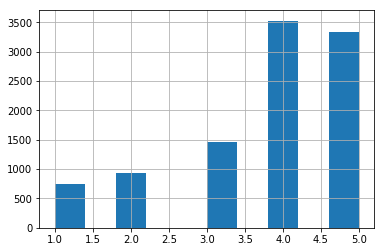

In [6]:
data.stars.hist()

Most of the restaurants recieved 4-5 stars. We see there is skewness towards to higer ratings

In [8]:
print(data.business_id.nunique())
print(data.user_id.nunique())

4174
6403


We have 4174 businesses and 6403 unique customers. 

Our total data set includes 10000 rows, which means on average one customer reviewed two businesses. This is a very small data set for a recommender system. 

Especially finding similarities with a pearson correlation on this data set will result all 0 correlations. Because rule of thum for pearson correlation is around 25.

In [9]:
print(data.cool.nunique())
print(np.sort(data.cool.unique()))
print(data.useful.nunique())
print(np.sort(data.useful.unique()))
print(data.funny.nunique())
print(np.sort(data.funny.unique()))

29
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 27 28 32 38 77]
28
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 23 24 28
 30 31 38 76]
29
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 27 30 39 57]


cool, useful, funny features will not be included in our model for two reasons:
    
    1. review and stars features explicitly mentioned in the description
    
    2. limited time did not allow detailed exploratory analysis of all features in data set
    
    Especially usefull column can be used as a filtering mechanizm for reviews, however I am not going to spend time on it.

In [10]:
data.isnull().sum()

business_id    0
date           0
review_id      0
stars          0
text           0
type           0
user_id        0
cool           0
useful         0
funny          0
dtype: int64

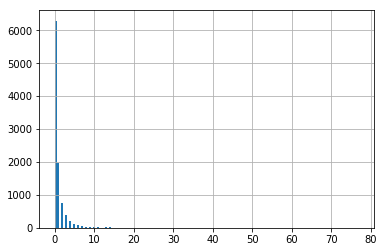

In [11]:
data.cool.hist(bins=150)

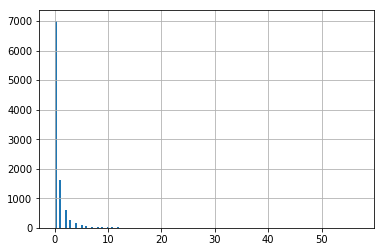

In [12]:
data.funny.hist(bins=150)

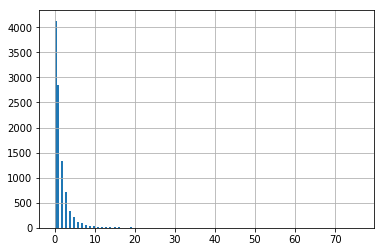

In [13]:
data.useful.hist(bins=150)

We mentioned cool, funny, usefull will not be included in our model. Plots shows that these features are highly skewed. Anybody who wants to spend more time on these features may try taking log of these features.

Since original data has ecrpyted columns, replacing numbers with these featues will benefit for clairty and easy modelling

In [5]:
from sklearn.preprocessing import LabelEncoder
labelbusines = LabelEncoder()
labelreview = LabelEncoder()
labeluser = LabelEncoder()
data.business_id = labelbusines.fit_transform(data.business_id)
data.review_id = labelreview.fit_transform(data.review_id)
data.user_id = labeluser.fit_transform(data.user_id)

In [15]:
data.describe()

,business_id,review_id,stars,user_id,cool,useful,funny
count,10000.000000,10000.00000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,2094.555600,4999.50000,3.777500,3177.751700,0.876800,1.409300,0.701300
std,1205.622291,2886.89568,1.214636,1865.012161,2.067861,2.336647,1.907942
min,0.000000,0.00000,1.000000,0.000000,0.000000,0.000000,0.000000
25%,1058.000000,2499.75000,3.000000,1531.000000,0.000000,0.000000,0.000000
50%,2114.500000,4999.50000,4.000000,3195.500000,0.000000,1.000000,0.000000
75%,3134.000000,7499.25000,5.000000,4800.000000,1.000000,2.000000,1.000000
max,4173.000000,9999.00000,5.000000,6402.000000,77.000000,76.000000,57.000000


In [118]:
data = data.sort_values('user_id')

Sample to show how to get stars of businesses

In [18]:
data[data.user_id==0].stars[data[data.user_id==0].business_id==2640]

2449    5
Name: stars, dtype: int64

For anybody who wants to return encryped business names Instead of id numbers

In [19]:
inv = labeluser.inverse_transform(data.user_id)
print(inv)

['--65q1FpAL_UQtVZ2PTGew' '--65q1FpAL_UQtVZ2PTGew'
 '--65q1FpAL_UQtVZ2PTGew' ... 'zxnoE5IjuWoI9mF1gwyg5w'
 'zzhdnNeg65wupOXqYtGyJw' 'zzmRKNph-pBHDL2qwGv9Fw']


/Users/muratyalcin/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


In [88]:
# split data as a train and test
from sklearn.model_selection import train_test_split
train, test = train_test_split(data, test_size=0.5)

We need to create an array, customers in lines, businesses in columns and ratings filled to appropriate positions

In [119]:
# Getting the number of users and businesses
nb_users = data.user_id.nunique()
nb_business = data.business_id.nunique()
# Converting the data into an array with customers in lines and businesses in columns
def convert(data):
    new_data = []
    for id_users in range(nb_users):
        id_business = data.business_id[data.user_id == id_users]
        id_ratings = data.stars[data.user_id == id_users]
        ratings = np.zeros(nb_business)
        ratings[id_business] = id_ratings
        new_data.append(list(ratings))
    return new_data

In [23]:
data_matrix = convert(data)

In [24]:
# Unit test to verify data conversion is correct
print(data_matrix[0][2640] == data[data.user_id==0].stars[data[data.user_id==0].business_id==2640])
print(data_matrix[0][3589] == data[data.user_id==0].stars[data[data.user_id==0].business_id==3589])
print(data_matrix[0][3250] == data[data.user_id==0].stars[data[data.user_id==0].business_id==3250])

2449    True
Name: stars, dtype: bool
2423    True
Name: stars, dtype: bool
2710    True
Name: stars, dtype: bool


In [90]:
# convert train and test data sets 
training_set = convert(train)
test_set = convert(test)

In [27]:
# import necessary torch libraries
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.optim as optim
import torch.utils.data
from torch.autograd import Variable

Below code is for Restricted Boltzman Machines 

Both RBM and Auto encoder codes taken from SuperDataScience team. Sklearn is also have buildin BernulliRBM() function. Both are applying the same math functions 

Since I modified and added more functions to RBM class, I prefered to use SuperDataScience team's codes.

In [28]:
# Converting the data into Torch tensors
training_set = torch.FloatTensor(training_set)
test_set = torch.FloatTensor(test_set)

# Converting the ratings into binary ratings 1 (Liked) or 0 (Not Liked)
training_set[training_set == 0] = -1
training_set[training_set == 1] = 0
training_set[training_set == 2] = 0
training_set[training_set >= 3] = 1
test_set[test_set == 0] = -1
test_set[test_set == 1] = 0
test_set[test_set == 2] = 0
test_set[test_set >= 3] = 1

# Creating the architecture of the Neural Network
class RBM():
    def __init__(self, nv, nh): # nv = number of visible nodes, vh = number of hidden nodes
        # initialize weights and bias using torch random number generator
        self.W = torch.randn(nh, nv)
        self.a = torch.randn(1, nh) # bias for hidden nodes
        self.b = torch.randn(1, nv) # bias for visible nodes
    def sample_h(self, x): # x = visible neurons v, in the probabilities (ph given v (sigmoid))
        wx = torch.mm(x, self.W.t())
        activation = wx + self.a.expand_as(wx) # add bias
        p_h_given_v = torch.sigmoid(activation) # apply activation
        return p_h_given_v, torch.bernoulli(p_h_given_v)
    def sample_v(self, y):
        wy = torch.mm(y, self.W)
        activation = wy + self.b.expand_as(wy)
        p_v_given_h = torch.sigmoid(activation)
        return p_v_given_h, torch.bernoulli(p_v_given_h)
    def train(self, v0, vk, ph0, phk):
        #self.W += torch.mm(v0.t(), ph0) - torch.mm(vk.t(), phk)
        self.W += (torch.mm(v0.t(),ph0) - torch.mm(vk.t(),phk)).t()
        self.b += torch.sum((v0 - vk), 0)
        self.a += torch.sum((ph0 - phk), 0)
nv = len(training_set[0])
nh = 20 # tune this paramater
batch_size = 32 # tune this paramater
rbm = RBM(nv, nh)


In [ ]:
#Due to the time and computer power limitation, I kept the grid search limites. 

#If you have enough time and power, you can try these:
    
params = {'nh': [10,20,30,40,50],
         'batch_size' : [16,32,64,128,256],
         'nb_epoch' : [50,80,100,200],
         'activation' : ['sigmoid', 'tanh']}
    

In [32]:
# Training the RBM
nb_epoch = 20 # tune this paramater
for epoch in range(1, nb_epoch + 1):
    train_loss = 0
    s = 0.
    for id_user in range(0, nb_users - batch_size, batch_size):
        vk = training_set[id_user:id_user+batch_size]
        v0 = training_set[id_user:id_user+batch_size]
        ph0,_ = rbm.sample_h(v0)
        for k in range(10):
            _,hk = rbm.sample_h(vk)
            _,vk = rbm.sample_v(hk)
            vk[v0<0] = v0[v0<0]
        phk,_ = rbm.sample_h(vk)
        rbm.train(v0, vk, ph0, phk)
        train_loss += torch.mean(torch.abs(v0[v0>=0] - vk[v0>=0]))
        s += 1.
    print('epoch: '+str(epoch)+' loss: '+str(train_loss/s))

epoch: 1 loss: tensor(0.1204)
epoch: 2 loss: tensor(0.1183)
epoch: 3 loss: tensor(0.1168)
epoch: 4 loss: tensor(0.1276)
epoch: 5 loss: tensor(0.1153)
epoch: 6 loss: tensor(0.1186)
epoch: 7 loss: tensor(0.1262)
epoch: 8 loss: tensor(0.1200)
epoch: 9 loss: tensor(0.1295)
epoch: 10 loss: tensor(0.1178)
epoch: 11 loss: tensor(0.1187)
epoch: 12 loss: tensor(0.1237)
epoch: 13 loss: tensor(0.1181)
epoch: 14 loss: tensor(0.1193)
epoch: 15 loss: tensor(0.1212)
epoch: 16 loss: tensor(0.1152)
epoch: 17 loss: tensor(0.1180)
epoch: 18 loss: tensor(0.1167)
epoch: 19 loss: tensor(0.1187)
epoch: 20 loss: tensor(0.1167)


In [ ]:
# Testing the RBM  ####### Modified version

def predict(id_user):
    v = training_set[id_user:id_user+1]
    #vt = test_set[id_user:id_user+1]
    _,h = rbm.sample_h(v)
    _,v = rbm.sample_v(h) 
    return v

print(predict(1))

In [34]:
# Testing the RBM
test_loss = 0
s = 0.
for id_user in range(nb_users):
    v = training_set[id_user:id_user+1]
    vt = test_set[id_user:id_user+1]
    if len(vt[vt>=0]) > 0:
        _,h = rbm.sample_h(v)
        _,v = rbm.sample_v(h) # v is the prediction result
        test_loss += torch.mean(torch.abs(vt[vt>=0] - v[vt>=0]))
        s += 1.
print('test loss: '+str(test_loss/s))

test loss: tensor(0.3199)


Train is loss is 0.1 and test loss is 0.32 indicates overfitting. 

Reducing the hidden layer size and number of layers may help overfitting problem. 

Getting more data is another solution to overfitting problem.

RBM will be used to recommend according to ratings. We need to create business features to catch user input.

I will use NLP technique to get most important words in reviews. From these words, I will manually select the words represents the business.

I will also go online and find the words represents restaurant businesses. I will combine both words and create business features matrix.

# Tf - idf

In [25]:
import nltk
import string
import re
import numpy as np
import pandas as pd
import pickle
#import lda

import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="white")

from nltk.stem.porter import *
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.corpus import stopwords
from sklearn.feature_extraction import stop_words

from collections import Counter
from wordcloud import WordCloud
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation

import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls
%matplotlib inline

import bokeh.plotting as bp
from bokeh.models import HoverTool, BoxSelectTool
from bokeh.models import ColumnDataSource
from bokeh.plotting import figure, show, output_notebook
#from bokeh.transform import factor_cmap

import warnings
warnings.filterwarnings('ignore')
import logging
logging.getLogger("lda").setLevel(logging.WARNING)

In [26]:
stop = set(stopwords.words('english'))
def tokenize(text):
    """
    sent_tokenize(): segment text into sentences
    word_tokenize(): break sentences into words
    """
    try: 
        regex = re.compile('[' +re.escape(string.punctuation) + '0-9\\r\\t\\n]')
        text = regex.sub(" ", text) # remove punctuation
        
        tokens_ = [word_tokenize(s) for s in sent_tokenize(text)]
        tokens = []
        for token_by_sent in tokens_:
            tokens += token_by_sent
        tokens = list(filter(lambda t: t.lower() not in stop, tokens))
        filtered_tokens = [w for w in tokens if re.search('[a-zA-Z]', w)]
        filtered_tokens = [w.lower() for w in filtered_tokens if len(w)>=3]
        
        return filtered_tokens
            
    except TypeError as e: print(text,e)

In [37]:
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer(min_df=10,
                             max_features=190000,
                             tokenizer=tokenize,
                             ngram_range=(1, 2))

In [38]:
all_desc = data['text'].values # Combine all reviews into a bag
vz = vectorizer.fit_transform(list(all_desc))

In [39]:
#  create a dictionary mapping the tokens to their tfidf values
tfidf = dict(zip(vectorizer.get_feature_names(), vectorizer.idf_))
tfidf = pd.DataFrame(columns=['tfidf']).from_dict(
                    dict(tfidf), orient='index')
tfidf.columns = ['tfidf']

In [40]:
# high tf-idf good information for our model
tfidf.sort_values(by=['tfidf'], ascending=False).head(20)

,tfidf
service quality,7.812545
service definitely,7.812545
favorite mexican,7.812545
ufc,7.812545
meat chicken,7.812545
favors,7.812545
service poor,7.812545
feel right,7.812545
felt little,7.812545
service terrible,7.812545


# Create business features

In [20]:
business_features = ['veggie','pizza','breakfast','steakhouse','chicken','mediterranean','mexican',
                    'chinese','seafood','italian','korean','american','sushi','vietnamese',
                    'ufc','sesame chicken','meat chicken','shank','shave','fast food',
                    'cafe','dining','bar','barbecue','bistro','food truck','sandwich','blues',
                    'self-service','food burger','family','scottsdale','farmer market',
                    'cheap','expensive']

Note : In a normal project creating a business_features by itself requires several weeks or months

# Create business features matrix

In [7]:
# Create an empty matrix
business_features_df = pd.DataFrame(columns = business_features, index = range(0,data.business_id.nunique()))
business_features_df.shape

(4174, 35)

In [8]:
# Fill the matrix with 1 if review includes feature, 0 if not
for feature in business_features:
    for i in range(data.shape[0]):
        if feature in data.text[i]:
            business_features_df[feature][i]=1
        else: business_features_df[feature][i]=0

In [75]:
business_features_df.head(2)

,veggie,pizza,breakfast,steakhouse,chicken,mediterranean,mexican,chinese,seafood,italian,...,food truck,sandwich,blues,self-service,food burger,family,scottsdale,farmer market,cheap,expensive
0,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [76]:
business_features_df.tail(2)

,veggie,pizza,breakfast,steakhouse,chicken,mediterranean,mexican,chinese,seafood,italian,...,food truck,sandwich,blues,self-service,food burger,family,scottsdale,farmer market,cheap,expensive
4172,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4173,0,0,0,0,1,0,0,0,0,0,...,0,1,0,0,0,0,0,0,1,0


In [107]:
import os
os.getcwd()

'/Users/muratyalcin/Desktop/Data Science/challenge'

In [7]:
business_features_df.to_csv('business_features_df.csv')

In [21]:
business_features_df = pd.read_csv('business_features_df.csv', index_col=0)

In [9]:
# Let's find features not helpful (include no business, nunique=1)
const_cols = [c for c in business_features_df.columns if business_features_df[c].nunique(dropna=False)==1 ]
const_cols

[]

I removed constant columns because they were useless. Now we don't have constant columns. Great!!! Business features represent at least one business. 

In [69]:
sum(business_features_df.sum(axis=1)==0)

2152

I shuttled between business features and how many businesses that I covered with these features. Initially, 3047 businesses represented neither of these features. I found more features and check the number businesses represented by these features. After several back and forths, finally I was able to lower the number to the 2152. It means that with current business features, 2152 businesses can not be classified. As I mentioned before this step requires more time and effort.

# Auto Encoders

In [24]:
#load data
data = pd.read_csv('dataset_food_online.txt', sep=',', encoding = 'latin-1')

In [25]:
from sklearn.preprocessing import LabelEncoder
labelbusines = LabelEncoder()
labelreview = LabelEncoder()
labeluser = LabelEncoder()
data.business_id = labelbusines.fit_transform(data.business_id)
data.review_id = labelreview.fit_transform(data.review_id)
data.user_id = labeluser.fit_transform(data.user_id)

In [26]:
data = data.sort_values('user_id')

In [27]:
# split data as a train and test
from sklearn.model_selection import train_test_split
train, test = train_test_split(data, test_size=0.5)

In [28]:
# Getting the number of users and businesses
nb_users = data.user_id.nunique()
nb_business = data.business_id.nunique()
# Converting the data into an array with customers in lines and businesses in columns
def convert(data):
    new_data = []
    for id_users in range(nb_users):
        id_business = data.business_id[data.user_id == id_users]
        id_ratings = data.stars[data.user_id == id_users]
        ratings = np.zeros(nb_business)
        ratings[id_business] = id_ratings
        new_data.append(list(ratings))
    return new_data

In [29]:
# convert train and test data sets 
training_set = convert(train)
test_set = convert(test)

In [38]:
# Converting the data into Torch tensors
training_set = torch.FloatTensor(training_set)
test_set = torch.FloatTensor(test_set)

# Creating the architecture of the Neural Network
class SAE(nn.Module):
    def __init__(self, ):
        super(SAE, self).__init__()
        self.fc1 = nn.Linear(nb_business, 20)
        self.fc2 = nn.Linear(20, 10)
        self.fc3 = nn.Linear(10, 20)
        self.fc4 = nn.Linear(20, nb_business)
        self.activation = nn.Sigmoid()
    def forward(self, x):
        x = self.activation(self.fc1(x))
        x = self.activation(self.fc2(x))
        x = self.activation(self.fc3(x))
        x = self.fc4(x)
        return x
    def save(self):
        torch.save({'state_dict': self.rbm.state_dict(),
                    'optimizer' : self.optimizer.state_dict(),
                   }, 'last_brain.pth')

    def load(self):
        if os.path.isfile('last_brain.pth'):
            print("=> loading checkpoint... ")
            checkpoint = torch.load('last_brain.pth')
            self.model.load_state_dict(checkpoint['state_dict'])
            self.optimizer.load_state_dict(checkpoint['optimizer'])
            print("done !")
        else:
            print("no checkpoint found...")
sae = SAE()
criterion = nn.MSELoss()
optimizer = optim.RMSprop(sae.parameters(), lr = 0.01, weight_decay = 0.5)

In [39]:
# Training the SAE
nb_epoch = 50
for epoch in range(1, nb_epoch + 1):
    train_loss = 0
    s = 0.
    for id_user in range(nb_users):
        input = Variable(training_set[id_user]).unsqueeze(0)
        target = input.clone()
        if torch.sum(target.data > 0) > 0:
            output = sae(input)
            target.require_grad = False
            output[target == 0] = 0
            loss = criterion(output, target)
            mean_corrector = nb_business/float(torch.sum(target.data > 0) + 1e-10)
            loss.backward()
            train_loss += np.sqrt(loss.data[0]*mean_corrector)
            s += 1.
            optimizer.step()
    print('epoch: '+str(epoch)+' loss: '+str(train_loss/s))


/Users/muratyalcin/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:16: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number
  app.launch_new_instance()


epoch: 1 loss: tensor(3.7719)
epoch: 2 loss: tensor(3.6825)
epoch: 3 loss: tensor(3.6058)
epoch: 4 loss: tensor(3.4692)
epoch: 5 loss: tensor(3.3425)
epoch: 6 loss: tensor(3.1515)
epoch: 7 loss: tensor(3.0109)
epoch: 8 loss: tensor(2.8360)
epoch: 9 loss: tensor(2.7305)
epoch: 10 loss: tensor(2.5877)
epoch: 11 loss: tensor(2.5084)
epoch: 12 loss: tensor(2.3876)
epoch: 13 loss: tensor(2.3250)
epoch: 14 loss: tensor(2.2195)
epoch: 15 loss: tensor(2.1689)
epoch: 16 loss: tensor(2.0753)
epoch: 17 loss: tensor(2.0342)
epoch: 18 loss: tensor(1.9498)
epoch: 19 loss: tensor(1.9162)
epoch: 20 loss: tensor(1.8389)
epoch: 21 loss: tensor(1.8110)
epoch: 22 loss: tensor(1.7402)
epoch: 23 loss: tensor(1.7168)
epoch: 24 loss: tensor(1.6519)
epoch: 25 loss: tensor(1.6324)
epoch: 26 loss: tensor(1.5723)
epoch: 27 loss: tensor(1.5562)
epoch: 28 loss: tensor(1.4999)
epoch: 29 loss: tensor(1.4867)
epoch: 30 loss: tensor(1.4338)
epoch: 31 loss: tensor(1.4233)
epoch: 32 loss: tensor(1.3737)
epoch: 33 loss: t

In [62]:
# Testing the SAE
test_loss = 0
s = 0.
for id_user in range(nb_users):
    input = Variable(training_set[id_user]).unsqueeze(0)
    target = Variable(test_set[id_user])
    if torch.sum(target.data > 0) > 0:
        output = sae(input)
        target.require_grad = False
        output[0][target == 0] = 0
        loss = criterion(output[0], target)
        mean_corrector = nb_business/float(torch.sum(target.data > 0) + 1e-10)
        test_loss += np.sqrt(loss.data[0]*mean_corrector)
        s += 1.
print('test loss: '+str(test_loss/s))

/Users/muratyalcin/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number
  del sys.path[0]


test loss: tensor(2.1177)


## Start Building a Model

In [22]:
input = 'Veggie pizza pizza place, kid"s playground'

In [27]:
# Tokenize input
tokens = tokenize(input)

In [28]:
tokens

['veggie', 'pizza', 'pizza', 'place', 'kid', 'playground']

In [29]:
# Find non duplicate matches
matches = list({x for x in tokens if x in business_features})
matches

['pizza', 'veggie']

In [30]:
business_features_df = pd.read_csv('business_features_df.csv', index_col=0)

# Pull the businesses with these features

In [31]:
business = []
for i in range(business_features_df.shape[0]):
    if (business_features_df[matches] == 1).iloc[i].sum()==1:
        business.append(i)

In [32]:
business_index = business_features_df.iloc[business].index

# Now predict with RBM, whether customer will like these restaurants or not

# Bolzman Prediction

In [37]:
data1 = pd.read_csv('dataset_food_online.txt', sep=',', encoding = 'latin-1')

In [38]:
from sklearn.preprocessing import LabelEncoder
labelbusines = LabelEncoder()
labelreview = LabelEncoder()
labeluser = LabelEncoder()
data1.business_id = labelbusines.fit_transform(data1.business_id)
data1.review_id = labelreview.fit_transform(data1.review_id)
data1.user_id = labeluser.fit_transform(data1.user_id)
data1 = data1.sort_values('user_id')

In [5]:
data = pd.read_csv('dataset_food_online.txt', sep=',', encoding = 'latin-1')

In [6]:
from sklearn.preprocessing import LabelEncoder
labelbusines = LabelEncoder()
labelreview = LabelEncoder()
labeluser = LabelEncoder()
data.business_id = labelbusines.fit_transform(data.business_id)
data.review_id = labelreview.fit_transform(data.review_id)
data.user_id = labeluser.fit_transform(data.user_id)

In [7]:
data = data.sort_values('user_id')

In [8]:
# Getting the number of users and businesses
nb_users = data.user_id.nunique()
nb_business = data.business_id.nunique()

# Converting the data into an array with customers in lines and businesses in columns
def convert(data):
    new_data = []
    for id_users in range(nb_users):
        id_business = data.business_id[data.user_id == id_users]
        id_ratings = data.stars[data.user_id == id_users]
        ratings = np.zeros(nb_business)
        ratings[id_business] = id_ratings
        new_data.append(list(ratings))
    return new_data

In [9]:
data = convert(data)

In [10]:
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.optim as optim
import torch.utils.data
from torch.autograd import Variable

In [11]:
# Converting the data into Torch tensors
data = torch.FloatTensor(data)

# Converting the ratings into binary ratings 1 (Liked) or 0 (Not Liked)
data[data == 0] = -1
data[data == 1] = 0
data[data == 2] = 0
data[data >= 3] = 1

# Creating the architecture of the Neural Network
class RBM():
    def __init__(self, nv, nh): # nv = number of visible nodes, vh = number of hidden nodes
        # initialize weights and bias using torch random number generator
        self.W = torch.randn(nh, nv)
        self.a = torch.randn(1, nh) # bias for hidden nodes
        self.b = torch.randn(1, nv) # bias for visible nodes
    def sample_h(self, x): # x = visible neurons v, in the probabilities (ph given v (sigmoid))
        wx = torch.mm(x, self.W.t())
        activation = wx + self.a.expand_as(wx) # add bias
        p_h_given_v = torch.sigmoid(activation) # apply activation
        return p_h_given_v, torch.bernoulli(p_h_given_v)
    def sample_v(self, y):
        wy = torch.mm(y, self.W)
        activation = wy + self.b.expand_as(wy)
        p_v_given_h = torch.sigmoid(activation)
        return p_v_given_h, torch.bernoulli(p_v_given_h)
    def train(self, v0, vk, ph0, phk):
        #self.W += torch.mm(v0.t(), ph0) - torch.mm(vk.t(), phk)
        self.W += (torch.mm(v0.t(),ph0) - torch.mm(vk.t(),phk)).t()
        self.b += torch.sum((v0 - vk), 0)
        self.a += torch.sum((ph0 - phk), 0)
    def save(self):
        torch.save({'state_dict': self.rbm.state_dict(),
                    'optimizer' : self.optimizer.state_dict(),
                   }, 'last_brain.pth')

    def load(self):
        if os.path.isfile('last_brain.pth'):
            print("=> loading checkpoint... ")
            checkpoint = torch.load('last_brain.pth')
            self.model.load_state_dict(checkpoint['state_dict'])
            self.optimizer.load_state_dict(checkpoint['optimizer'])
            print("done !")
        else:
            print("no checkpoint found...")
    def save_checkpoint(state, is_best, filename='checkpoint.pth.tar'):
        torch.save(state, filename)
        if is_best:
            shutil.copyfile(filename, 'model_best.pth.tar')
            
nv = len(data[0])
nh = 20 # tune this paramater
batch_size = 2000 # tune this paramater
rbm = RBM(nv, nh)


In [12]:
# Training the RBM
nb_epoch = 10 # tune this paramater
for epoch in range(1, nb_epoch + 1):
    train_loss = 0
    s = 0.
#     print('s =',s)
    for id_user in range(0, nb_users - batch_size, batch_size):
        #print('id_user =,',id_user)
        vk = data[id_user:id_user+batch_size]
#         print('vk',vk)
        v0 = data[id_user:id_user+batch_size]
#         print('v0',v0)
        ph0,_ = rbm.sample_h(v0)
#         print(ph0)
        for k in range(10):
            _,hk = rbm.sample_h(vk)
            _,vk = rbm.sample_v(hk)
            vk[v0<0] = v0[v0<0]
        phk,_ = rbm.sample_h(vk)
#         print('phk',phk)
        rbm.train(v0, vk, ph0, phk)
        train_loss += torch.mean(torch.abs(v0[v0>=0] - vk[v0>=0]))
        s += 1.
    print('epoch: '+str(epoch)+' loss: '+str(train_loss/s))

epoch: 1 loss: tensor(0.4472)
epoch: 2 loss: tensor(0.3005)
epoch: 3 loss: tensor(0.2570)
epoch: 4 loss: tensor(0.2315)
epoch: 5 loss: tensor(0.2068)
epoch: 6 loss: tensor(0.1985)
epoch: 7 loss: tensor(0.1959)
epoch: 8 loss: tensor(0.1836)
epoch: 9 loss: tensor(0.1807)
epoch: 10 loss: tensor(0.1747)


In [13]:
def predict(id_user):
    v = data[id_user:id_user+1]
    #vt = test_set[id_user:id_user+1]
    _,h = rbm.sample_h(v)
    _,v = rbm.sample_v(h) 
    return v

In [14]:
id_user = 0
prediction = predict(id_user)
prediction

tensor([[1., 1., 0.,  ..., 1., 1., 1.]])

In [33]:
# get the businesses match with the user search and user will like
a = np.array(prediction[0][business_index])
b =a.astype(bool)
b

array([ True,  True,  True,  True, False,  True, False,  True,  True,
        True,  True,  True, False,  True,  True,  True,  True, False,
        True, False, False, False,  True, False,  True,  True,  True,
        True,  True, False, False,  True,  True,  True,  True,  True,
       False,  True,  True,  True,  True, False,  True,  True,  True,
       False, False, False,  True,  True, False,  True,  True,  True,
       False,  True,  True,  True, False, False,  True,  True, False,
        True,  True,  True,  True,  True,  True,  True, False,  True,
        True, False, False,  True, False, False,  True,  True,  True,
        True,  True, False, False,  True,  True,  True,  True,  True,
        True,  True,  True, False, False,  True,  True,  True,  True,
        True, False, False,  True,  True, False, False,  True,  True,
        True,  True,  True,  True, False,  True,  True,  True,  True,
       False,  True,  True, False,  True,  True,  True,  True, False,
       False, False,

In [34]:
business_index[b]

Int64Index([   1,    5,   12,   15,   44,  108,  116,  138,  175,  179,
            ...
            4070, 4071, 4105, 4108, 4114, 4131, 4134, 4150, 4166, 4171],
           dtype='int64', length=283)

In [39]:
# get the businesses with the highest rating and recommend to the customer
recommendation = data1.groupby('business_id').stars.mean().loc[business_index[b]].sort_values(ascending = False).index[:3]

In [41]:
list(recommendation)

[4171, 2043, 578]

# If search is not in features, Recommend with Auto Encoders

# Auto Encoders

Until this point, all steps are the same with the Bolzman Machine

In [14]:
# Converting the data into Torch tensors
data = torch.FloatTensor(data)

In [15]:
# Creating the architecture of the Neural Network
class SAE(nn.Module):
    def __init__(self, ):
        super(SAE, self).__init__()
        self.fc1 = nn.Linear(nb_business, 20)
        self.fc2 = nn.Linear(20, 10)
        self.fc3 = nn.Linear(10, 20)
        self.fc4 = nn.Linear(20, nb_business)
        self.activation = nn.Sigmoid()
    def forward(self, x):
        x = self.activation(self.fc1(x))
        x = self.activation(self.fc2(x))
        x = self.activation(self.fc3(x))
        x = self.fc4(x)
        return x
    def save(self):
        torch.save({'state_dict': self.rbm.state_dict(),
                    'optimizer' : self.optimizer.state_dict(),
                   }, 'last_brain.pth')

    def load(self):
        if os.path.isfile('last_brain.pth'):
            print("=> loading checkpoint... ")
            checkpoint = torch.load('last_brain.pth')
            self.model.load_state_dict(checkpoint['state_dict'])
            self.optimizer.load_state_dict(checkpoint['optimizer'])
            print("done !")
        else:
            print("no checkpoint found...")
sae = SAE()
criterion = nn.MSELoss()
optimizer = optim.RMSprop(sae.parameters(), lr = 0.01, weight_decay = 0.5)

In [16]:
# Training the SAE
nb_epoch = 10
for epoch in range(1, nb_epoch + 1):
    train_loss = 0
    s = 0.
    for id_user in range(nb_users):
        input = Variable(data[id_user]).unsqueeze(0)
        target = input.clone()
        if torch.sum(target.data > 0) > 0:
            output = sae(input)
            target.require_grad = False
            output[target == 0] = 0
            loss = criterion(output, target)
            mean_corrector = nb_business/float(torch.sum(target.data > 0) + 1e-10)
            loss.backward()
            train_loss += np.sqrt(loss.data[0]*mean_corrector)
            s += 1.
            optimizer.step()
    print('epoch: '+str(epoch)+' loss: '+str(train_loss/s))


/Users/muratyalcin/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:16: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number
  app.launch_new_instance()


epoch: 1 loss: tensor(3.7606)
epoch: 2 loss: tensor(3.5919)
epoch: 3 loss: tensor(3.3643)
epoch: 4 loss: tensor(3.0679)
epoch: 5 loss: tensor(2.8436)
epoch: 6 loss: tensor(2.6379)
epoch: 7 loss: tensor(2.4961)
epoch: 8 loss: tensor(2.3495)
epoch: 9 loss: tensor(2.2483)
epoch: 10 loss: tensor(2.1352)


In [17]:
# Testing the SAE
def predictAE(id_user):
    input = Variable(data[id_user]).unsqueeze(0)
    output = sae(input)
    return output

In [18]:
id_user = 0
result = predictAE(id_user)
result

tensor([[0.6030, 0.4843, 0.1525,  ..., 1.4676, 0.5593, 0.8115]],
       grad_fn=<ThAddmmBackward>)

In [19]:
result = result[0].detach().numpy()
result

array([0.6029761 , 0.4842577 , 0.15247007, ..., 1.4675696 , 0.55928624,
       0.8115103 ], dtype=float32)

In [20]:
ind = np.argpartition(result, -5)[-5:]
ind

array([2224, 4114, 1367,  833, 3626])

In [21]:
list(ind)[0:3]

[2224, 4114, 1367]

Step below can not be applied to the data set that I have been provided. But with large data set Collaborative Filtering with Pearson Correlation will work fine

# If search is not in features, Recommend with CF

In [ ]:
# Pull up the customer with his/her ratings
user = 5000
user_df = data1[data1.user_id == user]
user_df

In [ ]:
# Pull the customers rated the same restaurants with current customer
user_subset = data1[data1.business_id.isin(user_df.business_id).tolist()]
user_subset

In [ ]:
# Unit test to check we pulled correct data
user_df.shape[0] == data1[data1.business_id.isin(user_df.business_id).tolist()].business_id.nunique()

In [ ]:
# Group by user id
user_subset_group = user_subset.groupby(['user_id'])

In [ ]:
#Sorting it so users with businesses most in common with the input will have priority
user_subset_group = sorted(user_subset_group,  key=lambda x: len(x[1]), reverse=True)

In [ ]:
user_subset_group[0:3]

# Similarity of users to input user
Next, we are going to compare all customers to our specified customer and find the one that is most similar.
we're going to find out how similar each customer is to the input through the Pearson Correlation Coefficient. It is used to measure the strength of a linear association between two variables.

In [ ]:
for name, group in user_subset_group:
    print('name =', name)
    print('group =', group)

In [ ]:
user_df.sort_values(by='business_id')

In [ ]:
tempRatingList

In [ ]:
tempGroupList

In [ ]:
float(nRatings)

In [ ]:
from math import sqrt
#Store the Pearson Correlation in a dictionary, where the key is the user Id and the value is the coefficient
pearsonCorrelationDict = {}

#For every user group in our subset
for name, group in user_subset_group:
    #Let's start by sorting the input and current user group so the values aren't mixed up later on
    group = group.sort_values(by='business_id')
    user_df = user_df.sort_values(by='business_id')
    #Get the N for the formula
    
    nRatings = len(group)
    #Get the review scores for the restaurants that they both have in common
    
    temp_df = user_df[user_df['business_id'].isin(group['business_id'].tolist())]
    #And then store them in a temporary buffer variable in a list format to facilitate future calculations
    
    tempRatingList = temp_df['stars'].tolist()
    #Let's also put the current user group reviews in a list format
    tempGroupList = group['stars'].tolist()
    #Now let's calculate the pearson correlation between two users, so called, x and y
    Sxx = sum([i**2 for i in tempRatingList]) - pow(sum(tempRatingList),2)/float(nRatings)
    Syy = sum([i**2 for i in tempGroupList]) - pow(sum(tempGroupList),2)/float(nRatings)
    Sxy = sum( i*j for i, j in zip(tempRatingList, tempGroupList)) - sum(tempRatingList)*sum(tempGroupList)/float(nRatings)
    
    #If the denominator is different than zero, then divide, else, 0 correlation.
    if Sxx != 0 and Syy != 0:
        pearsonCorrelationDict[name] = Sxy/sqrt(Sxx*Syy)
    else:
        pearsonCorrelationDict[name] = 0


In [ ]:
pearsonCorrelationDict.items()

In [ ]:
pearsonDF = pd.DataFrame.from_dict(pearsonCorrelationDict, orient='index')
pearsonDF.columns = ['similarityIndex']
pearsonDF['user_id'] = pearsonDF.index
pearsonDF.index = range(len(pearsonDF))
pearsonDF.head()

The top 50 similar users to input user

In [ ]:
topUsers=pearsonDF.sort_values(by='similarityIndex', ascending=False)[0:50]
topUsers.head()

In [ ]:
ratings_df = data1[['business_id','user_id','stars']]

In [ ]:
topUsersRating=topUsers.merge(ratings_df, left_on='user_id', right_on='user_id', how='inner')
topUsersRating.head()

In [ ]:
#Multiplies the similarity by the user's ratings
topUsersRating['weightedRating'] = topUsersRating['similarityIndex']*topUsersRating['stars']
topUsersRating.head()

In [ ]:
#Applies a sum to the topUsers after grouping it up by userId
tempTopUsersRating = topUsersRating.groupby('business_id').sum()[['similarityIndex','weightedRating']]
tempTopUsersRating.columns = ['sum_similarityIndex','sum_weightedRating']
tempTopUsersRating.head()

In [ ]:
#Creates an empty dataframe
recommendation_df = pd.DataFrame()
#Now we take the weighted average
recommendation_df['weighted average recommendation score'] = tempTopUsersRating['sum_weightedRating']/tempTopUsersRating['sum_similarityIndex']
recommendation_df['business_id'] = tempTopUsersRating.index
recommendation_df.head()

In [ ]:
recommendation_df = recommendation_df.sort_values(by='weighted average recommendation score', ascending=False)
recommendation_df.head(10)

In [ ]:
data1.loc[data1['business_id'].isin(recommendation_df.head(10)['business_id'].tolist())]

Pearson correlation is not good choise for this data set where each customer has average 2 ratings. Good rule of thum is 25 for Pearson Correlation

# Thank You
# Murat Yalcin (Data Scientist / AI Specialist)